In [19]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.fftpack import dct, idct
from scipy.fft import fft, ifft
import librosa
import librosa.display
from IPython.display import Audio, display

### FDM Implementation

In [4]:
def fdm(X, fs, fc, data_type='columns', filter_type='dct', sort_fc='descend', remove_mean=False):
    if data_type == 'rows':
        X = np.transpose(X)
    else:
        axis = 0

    if remove_mean:
        X = X - np.mean(X, axis=0)

    N = X.shape[0]
    fc = np.sort(fc)
    if fc[0] != 0:
        fc = np.hstack((0, fc))
    if fc[-1] != fs / 2:
        fc = np.hstack((fc, fs / 2))

    if sort_fc == 'descend':
        fc[::-1].sort()

    if filter_type == 'dct':
        dct_type = 2
        K = np.round(2 * N * fc / fs).astype(int)
        no_of_subbands = K.shape[0] - 1
        Hk = np.zeros((N, 1, no_of_subbands))
    elif filter_type == 'dft':
        append_ratio = 0.02
        pad_rows = int(N * append_ratio)
        X_padded = np.pad(X, pad_width=((pad_rows, pad_rows), (0, 0)), mode="symmetric")
        L = X_padded.shape[0]
        N_fft = 2 * np.ceil(L / 2).astype(int)
        K = np.round(N_fft * fc / fs).astype(int)
        no_of_subbands = K.shape[0] - 1
        Hk = np.zeros((N_fft, 1, no_of_subbands))

    for i in range(no_of_subbands):
        if filter_type == 'dct':
            if sort_fc == 'ascend':
                Hk[K[i]:K[i + 1], :, i] = 1
            elif sort_fc == 'descend':
                Hk[K[i + 1]:K[i], :, i] = 1
        elif filter_type == 'dft':
            if sort_fc == 'ascend':
                Hk[K[i]:K[i + 1], :, i] = 1
                Hk[N_fft - K[i + 1]:N_fft - K[i], :, i] = 1
            elif sort_fc == 'descend':
                Hk[K[i + 1]:K[i], :, i] = 1
                Hk[N_fft - K[i]:N_fft - K[i + 1], :, i] = 1

    if filter_type == 'dct':
        Xk = dct(X, type=dct_type, n=N, axis=axis, norm='ortho')
        Yk = np.einsum('ij,ijk->ijk', Xk, Hk)
        Y = idct(Yk, type=dct_type, n=N, axis=axis, norm='ortho')
    elif filter_type == 'dft':
        Xk = 1 / L * fft(X_padded, n=N_fft, axis=axis)
        Yk = np.einsum('ij,ijk->ijk', Xk, Hk)
        Y = L * ifft(Yk, n=N_fft, axis=axis).real
        Y = Y[pad_rows:N + pad_rows, :, :]

    if X.shape[1] == 1:
        return np.squeeze(Y)
    return Y


### Sine Wave Generation and Processing

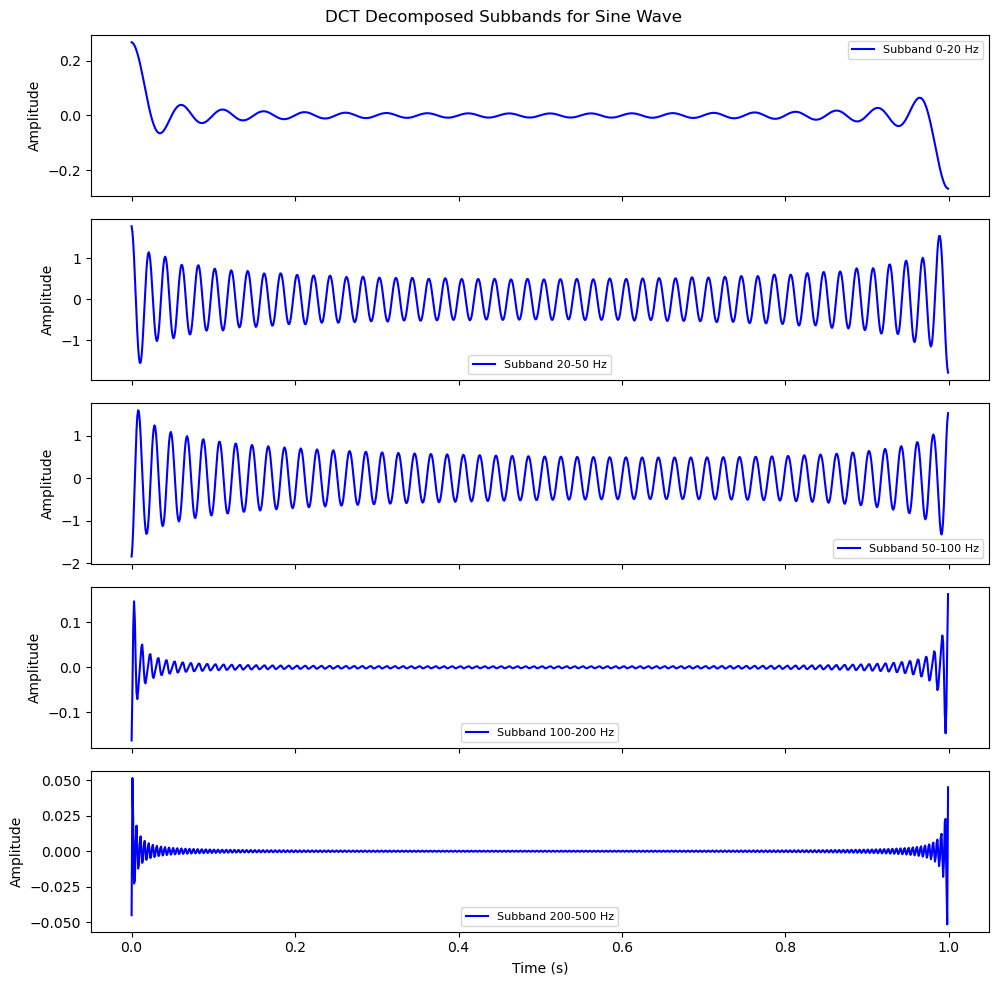

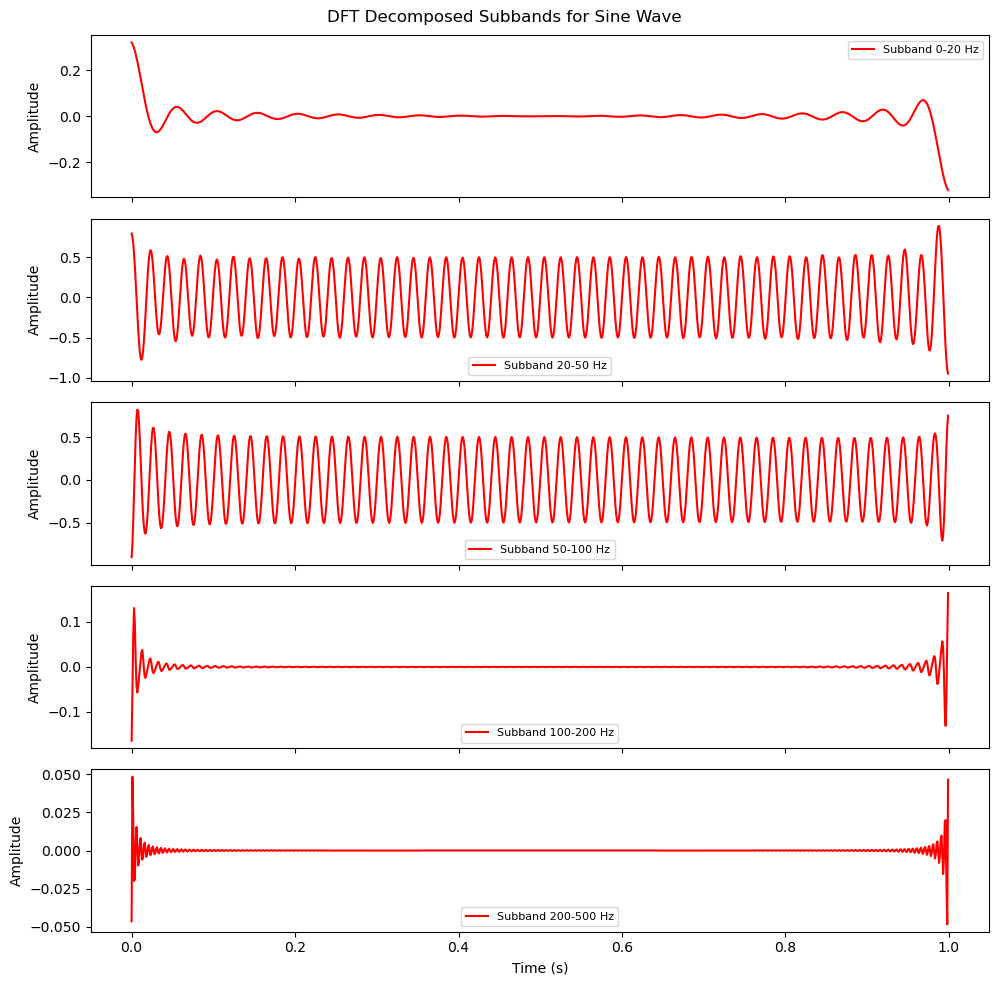

In [40]:
import matplotlib.pyplot as plt
import numpy as np

fs = 1000  # Sampling frequency
t = np.arange(0, 1, 1 / fs)
sine_wave = np.sin(2 * np.pi * 50 * t).reshape(-1, 1)  # 50 Hz sine wave

fc = [0, 20, 50, 100, 200, 500]

FIBFs_dct = fdm(sine_wave, fs, fc, filter_type='dct', sort_fc='ascend', remove_mean=True)
fig, axes = plt.subplots(len(fc) - 1, 1, figsize=(10, 10), sharex=True)
fig.suptitle("DCT Decomposed Subbands for Sine Wave")

for i in range(len(fc) - 1):
    axes[i].plot(t, FIBFs_dct[:, i], label=f"Subband {fc[i]}-{fc[i+1]} Hz", color='b')
    axes[i].legend(fontsize=8)
    axes[i].set_ylabel("Amplitude")
    plt.savefig(f"DCT_SineWave_Subband_{i+1}.png")

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

FIBFs_dft = fdm(sine_wave, fs, fc, filter_type='dft', sort_fc='ascend', remove_mean=True)
fig, axes = plt.subplots(len(fc) - 1, 1, figsize=(10, 10), sharex=True)
fig.suptitle("DFT Decomposed Subbands for Sine Wave")

for i in range(len(fc) - 1):
    axes[i].plot(t, FIBFs_dft[:, i], label=f"Subband {fc[i]}-{fc[i+1]} Hz", color='r')
    axes[i].legend(fontsize=8)
    axes[i].set_ylabel("Amplitude")
    plt.savefig(f"DFT_SineWave_Subband_{i+1}.png")

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()


### Audio File Processing

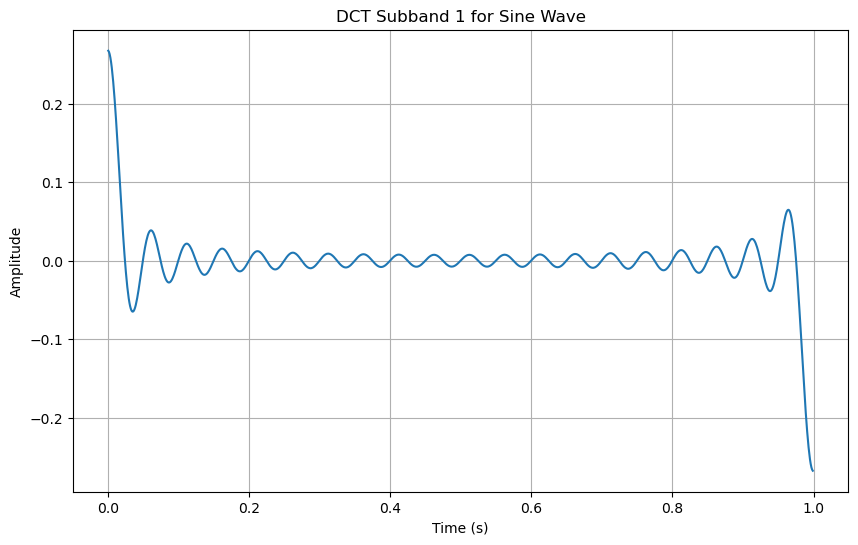

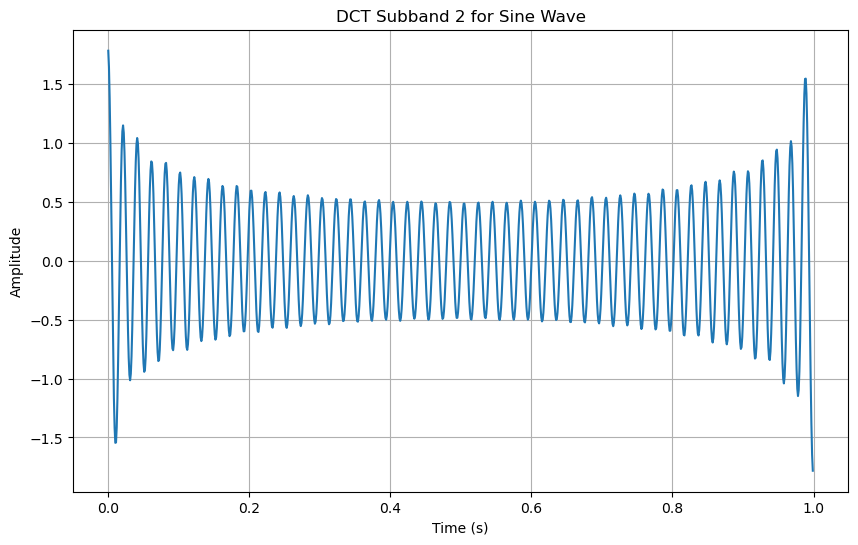

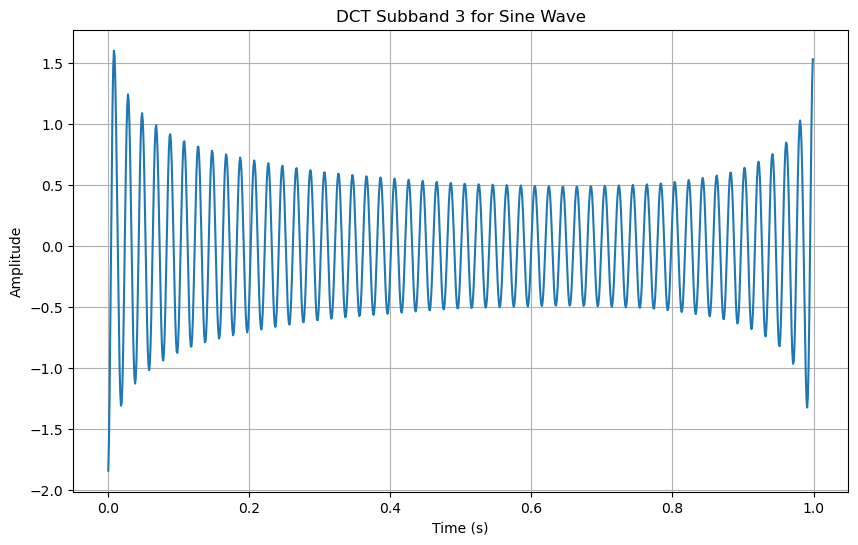

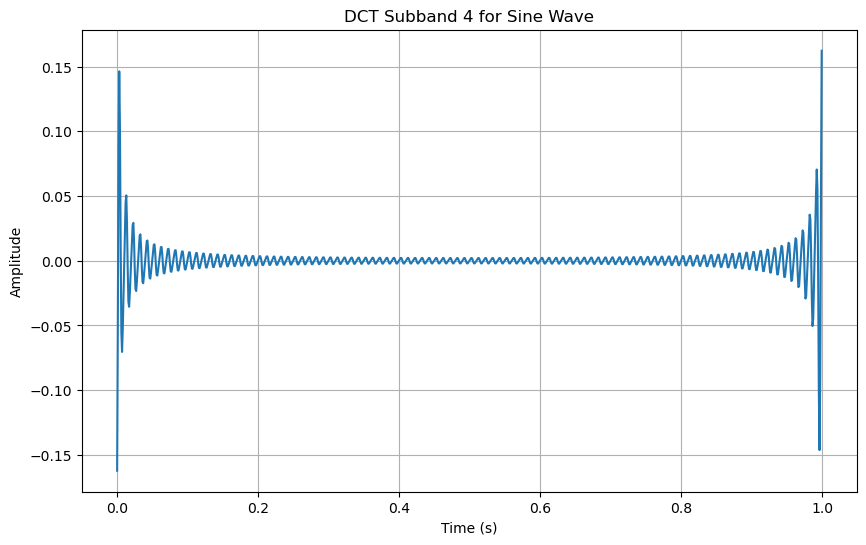

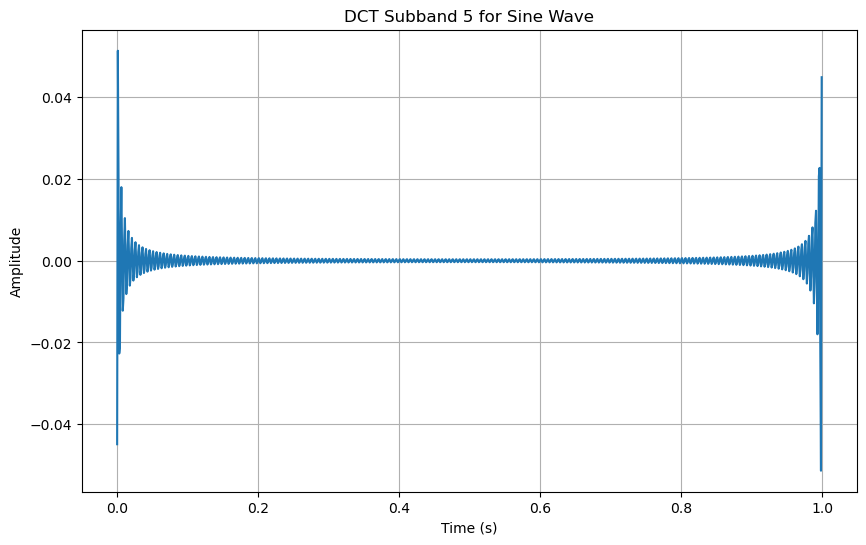

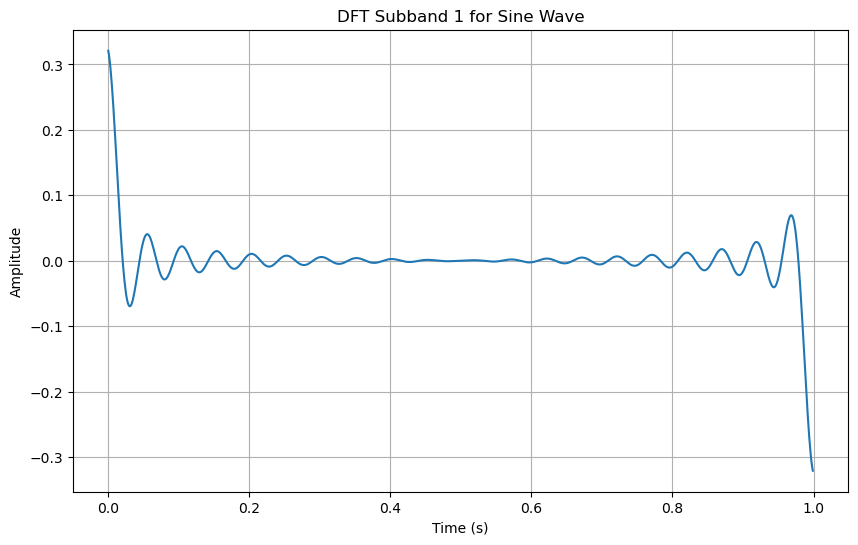

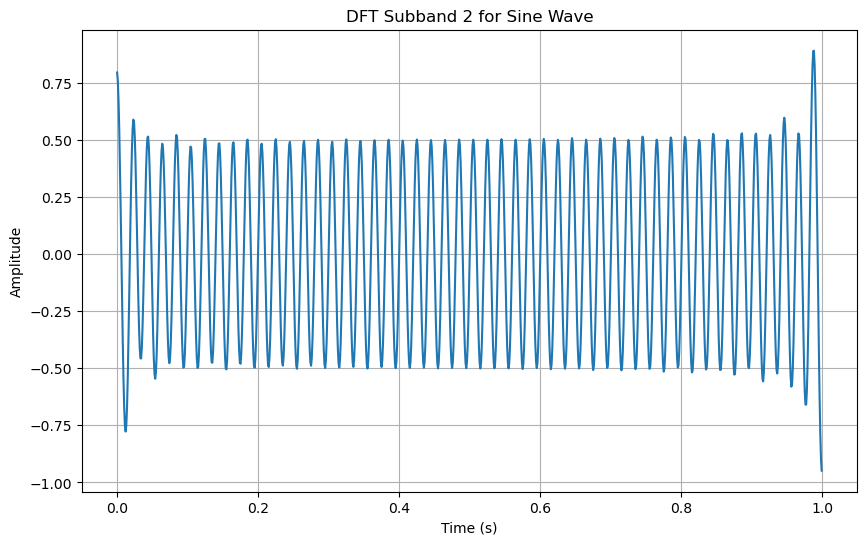

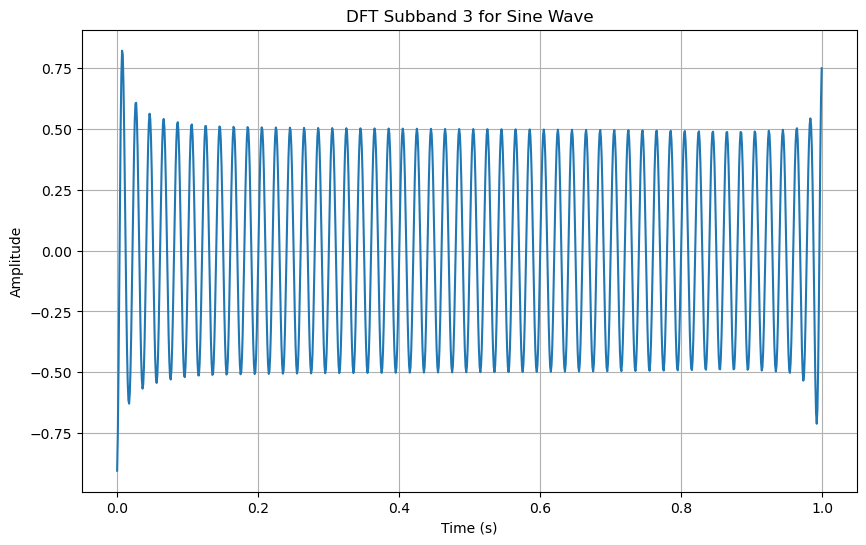

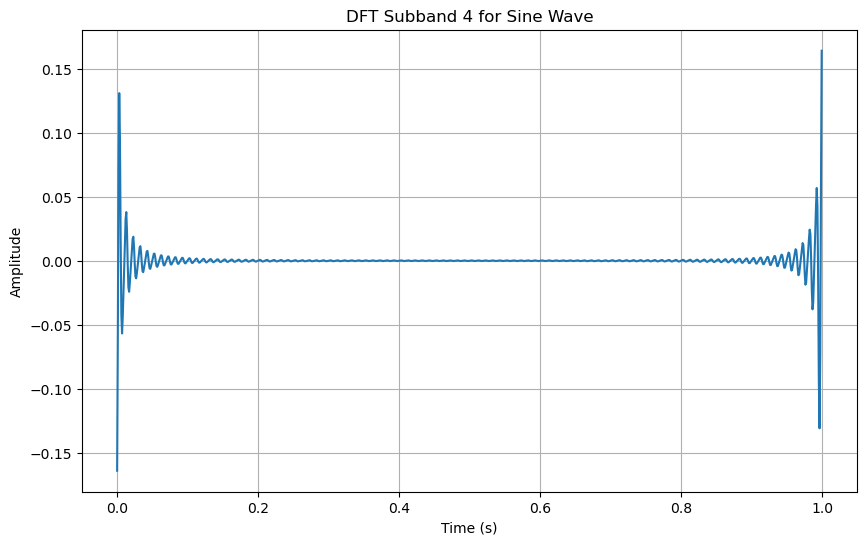

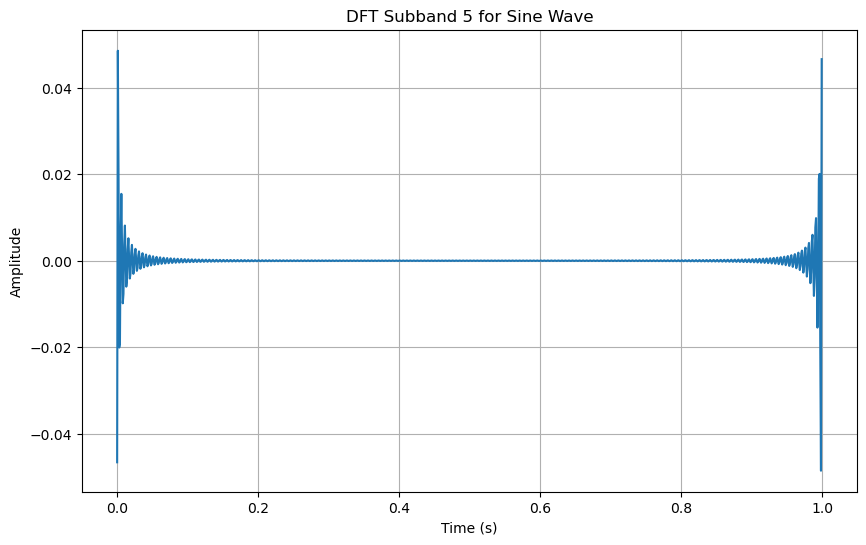

Playing Original Audio...


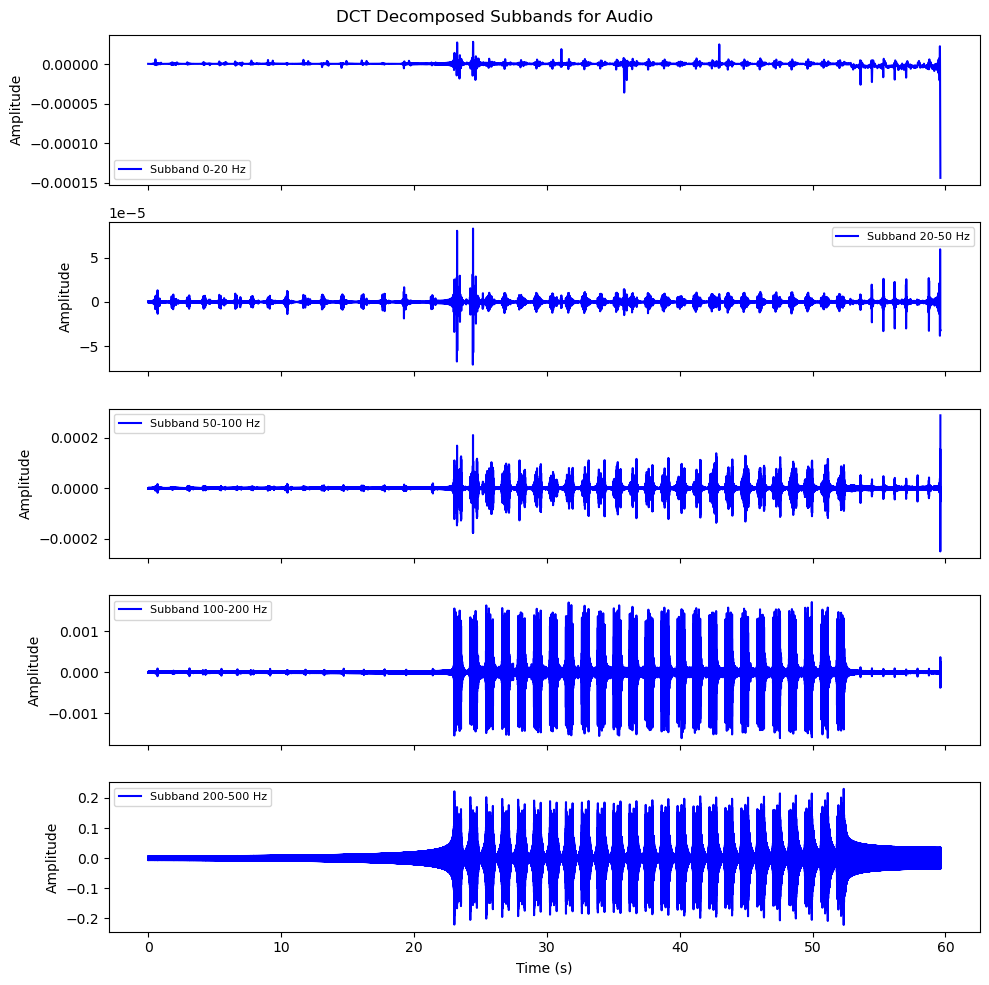

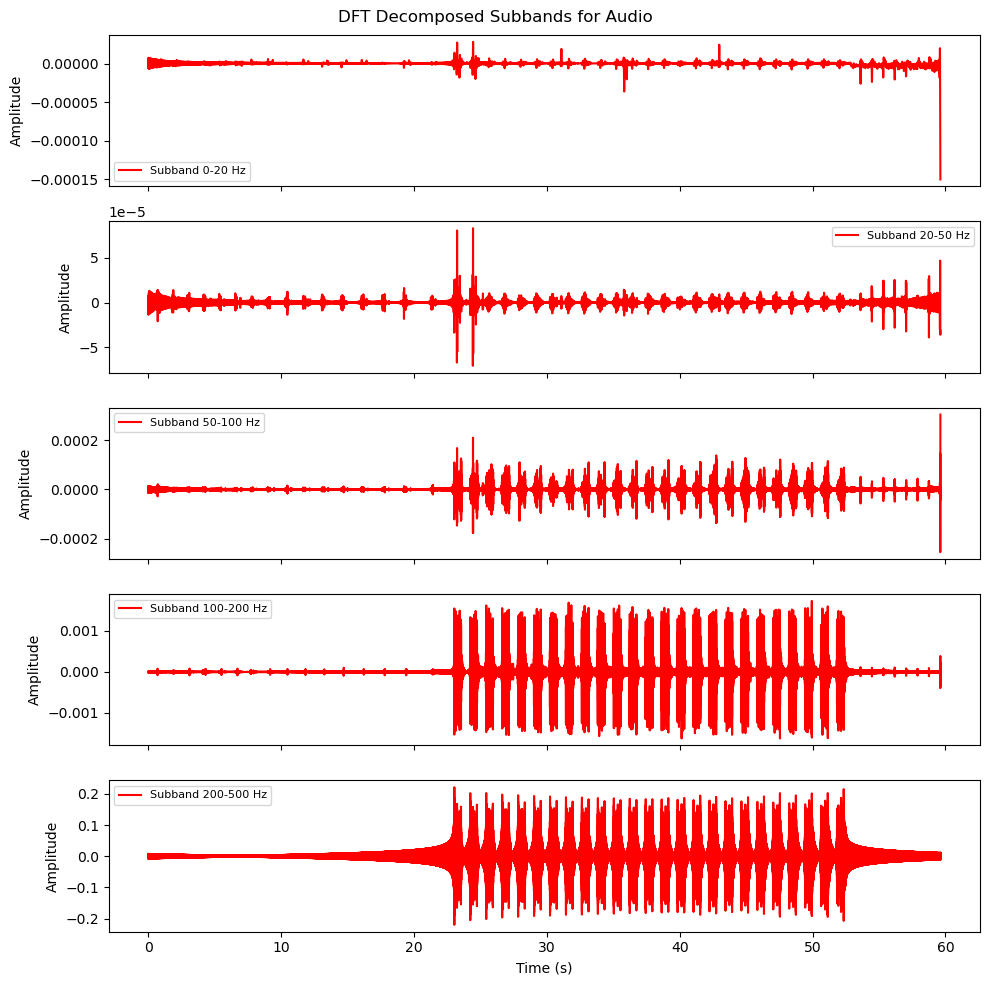

In [38]:
fs = 1000  # Sampling frequency
t = np.arange(0, 1, 1 / fs)
sine_wave = np.sin(2 * np.pi * 50 * t).reshape(-1, 1)  # 50 Hz sine wave

fc = [0, 20, 50, 100, 200, 500]

FIBFs_dct = fdm(sine_wave, fs, fc, filter_type='dct', sort_fc='ascend', remove_mean=True)
for i in range(FIBFs_dct.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.plot(t, FIBFs_dct[:, i])
    plt.title(f"DCT Subband {i + 1} for Sine Wave")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.savefig(f"DCT_Subband_{i + 1}.png")
    plt.show()

FIBFs_dft = fdm(sine_wave, fs, fc, filter_type='dft', sort_fc='ascend', remove_mean=True)
for i in range(FIBFs_dft.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.plot(t, FIBFs_dft[:, i])
    plt.title(f"DFT Subband {i + 1} for Sine Wave")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.savefig(f"DFT_Subband_{i + 1}.png")
    plt.show()

file = "audio1.mp3" 
y, fs = librosa.load(file, sr=None)

def play_audio(signal, rate, title):
    print(f"Playing {title}...")
    display(Audio(signal, rate=rate))

play_audio(y, fs, "Original Audio")

sort_fc = 'ascend'
remove_mean = True

FIBFs_dct = fdm(y.reshape(-1, 1), fs, fc, filter_type='dct', sort_fc=sort_fc, remove_mean=remove_mean)
FIBFs_dft = fdm(y.reshape(-1, 1), fs, fc, filter_type='dft', sort_fc=sort_fc, remove_mean=remove_mean)

t = np.arange(len(y)) / fs

fig, axes = plt.subplots(len(fc) - 1, 1, figsize=(10, 10), sharex=True)
fig.suptitle("DCT Decomposed Subbands for Audio")

for i in range(len(fc) - 1):
    axes[i].plot(t, FIBFs_dct[:, i], label=f"Subband {fc[i]}-{fc[i+1]} Hz", color='b')
    axes[i].legend(fontsize=8)
    axes[i].set_ylabel("Amplitude")
    plt.savefig(f"DCT_Audio_Subband_{i+1}.png")

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(len(fc) - 1, 1, figsize=(10, 10), sharex=True)
fig.suptitle("DFT Decomposed Subbands for Audio")

for i in range(len(fc) - 1):
    axes[i].plot(t, FIBFs_dft[:, i], label=f"Subband {fc[i]}-{fc[i+1]} Hz", color='r')
    axes[i].legend(fontsize=8)
    axes[i].set_ylabel("Amplitude")
    plt.savefig(f"DFT_Audio_Subband_{i+1}.png")

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()
